# Importación de Módulos

In [13]:
import pandas as pd
import numpy as np
import random
import plotly.express as px
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Importar los datos

In [14]:
# Importar los datos

# Guarda los nombres únicos de las primeras dos columnas.
index_col_names=['unit_id','time_cycle']
# Genera los nombres del primer set de columnas con formato, estas son las de operational setting n.
operat_set_col_names=['oper_set{}'.format(i) for i in range(1,4)]
# Genera los nombres del segundo set de columnas con formato, estas son las de sensor measurement n.
sensor_measure_col_names=['sm_{}'.format(i) for i in range(1,22)]
# Pone todos los títulos en una lista
all_col=index_col_names+operat_set_col_names+sensor_measure_col_names

# Importa los datos desde el .txt com su nombre de columna en un dataframe.
train_df=pd.read_csv('train.txt',delim_whitespace=True,names=all_col)
train_df

C:\Users\dave4\AppData\Local\Temp\ipykernel_23312\1475424004.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df=pd.read_csv('train.txt',delim_whitespace=True,names=all_col)


,unit_id,time_cycle,oper_set1,oper_set2,oper_set3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_12,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.00,28.58,17.1735
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.00,38.99,23.3619
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.00,14.83,8.8555
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.00,24.42,14.7832
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.00,10.99,6.4025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,129,42.0066,0.8400,40.0,445.00,551.02,1365.27,1147.43,3.91,...,130.21,2387.39,8062.87,9.4672,0.02,333,2212,100.00,10.57,6.2985
45914,218,130,42.0029,0.8415,40.0,445.00,550.07,1365.55,1142.21,3.91,...,130.24,2387.28,8062.05,9.4619,0.02,332,2212,100.00,10.40,6.2741
45915,218,131,41.9999,0.8400,40.0,445.00,549.92,1359.21,1150.15,3.91,...,129.86,2387.33,8062.73,9.4827,0.02,334,2212,100.00,10.37,6.1978
45916,218,132,35.0007,0.8419,60.0,449.44,556.55,1380.05,1145.49,5.48,...,182.03,2387.56,8043.21,9.4212,0.02,337,2223,100.00,14.70,8.6761


# Calcular RUL

In [15]:
# Primero se encuentra el ciclo de tiempo máximo para cada ID

#find maximum time cycle for each unit d
max_time_cycle=train_df.groupby('unit_id')['time_cycle'].max()
max_time_cycle
rul = pd.DataFrame(max_time_cycle).reset_index()
rul.columns = ['unit_id', 'max']
rul.head()

,unit_id,max
0,1,223
1,2,164
2,3,150
3,4,159
4,5,357


In [16]:
# Se calcula el RUL para cada fila con un id específico y se le resta al máximo.

train_df = train_df.merge(rul, on=['unit_id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['time_cycle']
train_df.drop('max', axis=1, inplace=True)
train_df[train_df.unit_id==1].iloc[:,[1,-1]]

,time_cycle,RUL
0,1,222
1,2,221
2,3,220
3,4,219
4,5,218
...,...,...
218,219,4
219,220,3
220,221,2
221,222,1


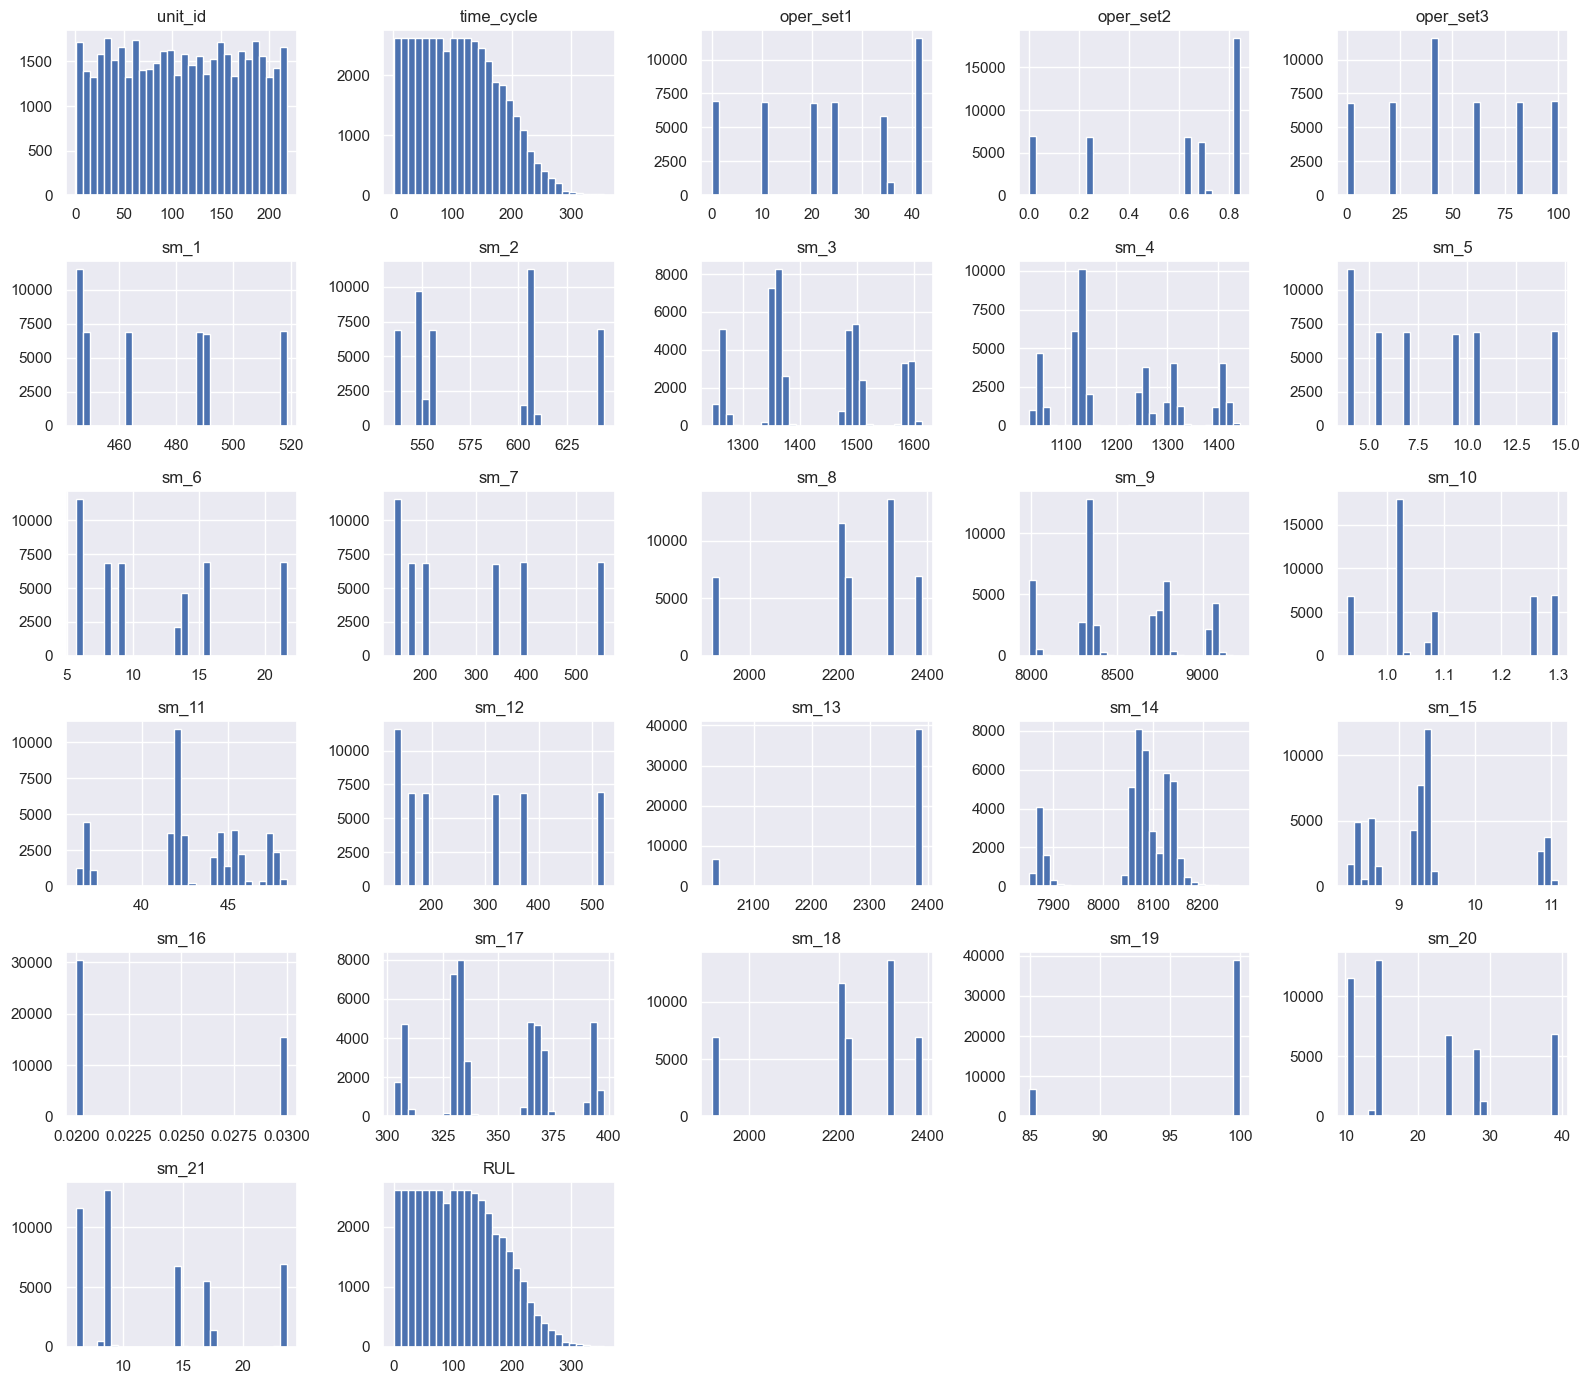

In [17]:
sns.set(font_scale=1) 
train_df.hist(bins=30, figsize=(16,14), color='b')
plt.tight_layout()
plt.show()

In [18]:
train_df.iloc[:,1:-1].corr()

,time_cycle,oper_set1,oper_set2,oper_set3,sm_1,sm_2,sm_3,sm_4,sm_5,sm_6,...,sm_12,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21
time_cycle,1.000000,0.003473,0.005575,0.000274,-0.001072,0.005619,0.027155,0.038198,-0.002039,-0.001753,...,-0.003694,0.001231,0.071030,0.033048,0.063947,0.027128,-0.000035,0.000537,-0.007669,-0.007735
oper_set1,0.003473,1.000000,0.944070,-0.236526,-0.964898,-0.867841,-0.787827,-0.840494,-0.987410,-0.976517,...,-0.951256,-0.028466,-0.263886,0.461295,-0.840640,-0.790628,-0.443949,-0.028214,-0.962121,-0.962094
oper_set2,0.005575,0.944070,1.000000,-0.384657,-0.886941,-0.811772,-0.761642,-0.837836,-0.934140,-0.929835,...,-0.919211,-0.066687,-0.356031,0.521131,-0.886204,-0.764962,-0.440888,-0.066521,-0.922367,-0.922311
oper_set3,0.000274,-0.236526,-0.384657,1.000000,0.148564,0.004370,-0.053529,0.026110,0.264139,0.231430,...,0.191662,-0.398303,-0.226750,0.163645,0.107336,-0.048482,-0.270175,-0.398198,0.193114,0.192972
sm_1,-0.001072,-0.964898,-0.886941,0.148564,1.000000,0.944026,0.870890,0.898268,0.986637,0.986683,...,0.973183,0.164004,0.354432,-0.543711,0.799580,0.873203,0.571773,0.163776,0.977990,0.977997
sm_2,0.005619,-0.867841,-0.811772,0.004370,0.944026,1.000000,0.982283,0.981479,0.916066,0.944327,...,0.969139,0.479953,0.625633,-0.778950,0.811421,0.983114,0.810141,0.479746,0.962672,0.962716
sm_3,0.027155,-0.787827,-0.761642,-0.053529,0.870890,0.982283,1.000000,0.989703,0.842947,0.884787,...,0.929554,0.620942,0.753071,-0.876608,0.809253,0.998687,0.895491,0.620743,0.917107,0.917162
sm_4,0.038198,-0.840494,-0.837836,0.026110,0.898268,0.981479,0.989703,1.000000,0.884255,0.919707,...,0.957183,0.544983,0.716351,-0.847379,0.861647,0.990403,0.844088,0.544782,0.946483,0.946517
sm_5,-0.002039,-0.987410,-0.934140,0.264139,0.986637,0.916066,0.842947,0.884255,1.000000,0.996315,...,0.979514,0.113651,0.331612,-0.526019,0.827026,0.845709,0.523828,0.113423,0.985746,0.985729
sm_6,-0.001753,-0.976517,-0.929835,0.231430,0.986683,0.944327,0.884787,0.919707,0.996315,1.000000,...,0.993108,0.198078,0.408542,-0.596138,0.843348,0.887215,0.594040,0.197854,0.996369,0.996361
